# Gradient/steepest descent

Gradient/steepest descent is arguably both the simplest and one of the slowest linesearch algorithms for unconstrained minimization.  From this perspective it provides an excellent starting point for performance improvements.
The algorithm is based on the iteration
$$
x_{k+1} = x_k - \alpha_k \nabla f(x_k),
$$
where $\alpha_k$ is the steplength, which is determined by a linesearch procedure.  Here we utilize the backtraking linesearch.

We begin with the implementation of the linesearch.

In [1]:
import numpy as np

In [2]:
def bcktrck_lsrch(x,p,f,df,c1):
    # f, df: function and its gradient
    # c1: sufficient decrease parameter
    # x,p: current point and linesearch direction
    # initial steplength and step reduction at each failed attempt
    alpha = 1.0
    rho   = 0.5
    # precompute some quantities outside of the loop
    f0    = f(x)
    pdf0  = df(x).dot(p)
    # do not spend more than MAX_ITER iterations in linesearch
    MAX_ITER = 20
    n_iter   = 0
    while (f(x+alpha*p) > f0 + c1*alpha*pdf0) and \
          (n_iter < MAX_ITER):
        alpha  *= rho
        n_iter += 1
    return alpha

In [3]:
def steepest_descent(x0,f,df,eps_grad):
    c1, c2 = 1.0E-04, 0.9
    xk = x0.copy()
    x_history = [xk.copy()]
    f_history = [f(xk)]
    
    while True:
        pk     = -df(xk)
        # Check the necessary optimality conditions
        if (np.linalg.norm(pk) < eps_grad):
            break
        alphak = bcktrck_lsrch(xk,pk,f,df,c1)
        # or 
        # alphak = bracketing_lsrch(xk,pk,f,df,c1,c2)
        xk    += alphak*pk
        x_history.append(xk.copy())
        f_history.append(f(xk))
    return xk, x_history, f_history

Below is the standard benchmark: Rosenbrock "banana" function.

In [4]:
def banana(x):
    return (1-x[0])**2 + 100*(x[1]-x[0]**2)**2

In [5]:
def d_banana(x):
    return np.array([-2*(1-x[0]) - 400*(x[1]-x[0]**2)*x[0], \
                     200*(x[1]-x[0]**2)])

Let us try out our implementation:

In [6]:
x0 = np.array([0.5,-1])
eps_grad = 1.0E-06

x, x_history, f_history = steepest_descent(x0,banana,d_banana,eps_grad)
print("Final f=%e, |df|=%e" % (banana(x),np.linalg.norm(d_banana(x))))

Final f=5.974222e-13, |df|=9.938928e-07


As with all first order methods, there is a lot of progress made in the beginning, after which not much is happening.

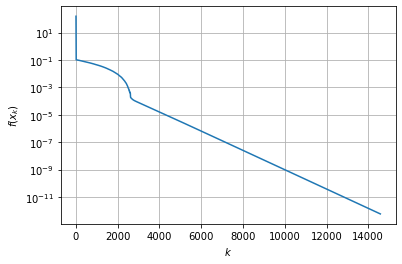

In [7]:
import matplotlib.pyplot as plt

plt.semilogy(f_history)
plt.grid(True)
plt.xlabel(r'$k$')
plt.ylabel(r'$f(x_k)$')
plt.show()

Let us plot the iterates on the countormap of the function.  Note the excessive 'zigzagging' once the method enters the 'valley'.  The initial 'overshoot' of the valley may be corrected by imposing more stringent sufficient decrease condition, that is, larger $c_1$.

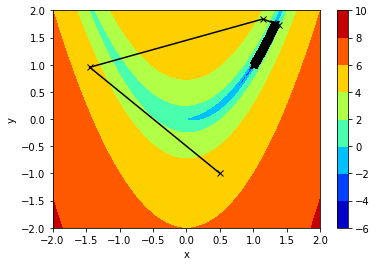

In [8]:
import matplotlib.cm as cm

xmin,xmax = -2,2
ymin,ymax = -2,2
xx = np.linspace(xmin,xmax,100)
yy = np.linspace(ymin,ymax,100)
X, Y = np.meshgrid(xx,yy)
with np.nditer([X, Y, None]) as it:
    for xi,yi,zi in it:
        zi[...] = np.log(banana(np.array([xi,yi])))
    Z = it.operands[2]
plt.contourf(X,Y,Z,cmap=cm.jet,extent=(xmin,xmax,ymin,ymax))

xhist = np.stack( x_history, axis=0 )
plt.plot(xhist[:,0],xhist[:,1],'-xk')

plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

Finally, here is an reference implementation of the bracketing linesearch, which guarantees Wolfe conditions at the end.  This is important, for example, for BFGS method.

In [9]:
def bracketing_lsrch(x,p,f,df,c1,c2):
    # linesearch, which guarantees Wolfe conditions
    alpha_min, alpha_max = 0.0, np.inf
    alpha = 1.0
    fx   = f(x)
    dfx  = df(x)
    dfxp = dfx.dot(p)
    while alpha < 1.0E+10:
        if np.abs(alpha_max-alpha_min)<1.0E-10:
            return alpha
        if f(x+alpha*p) > fx + alpha*c1*dfxp:
            # no sufficient decrease: too long step
            alpha_max = alpha
            alpha = 0.5*(alpha_max + alpha_min)
        elif df(x+alpha*p).dot(p) < c2*dfxp:
            # no curvature condition: too short step
            alpha_min = alpha
            if alpha_max == np.inf:
                alpha *= 2.0
            else:
                alpha = 0.5*(alpha_max + alpha_min)
        else:
            # we are done!
            return alpha
    raise ValueError('Steplength is way too long!')